In [1]:
# We load the competition data

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


# Packages

In [2]:
!pip install autoviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not cur

# Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from autoviz.AutoViz_Class import AutoViz_Class
from sklearn.impute import KNNImputer

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


# Predict the Introverts from the Extroverts

### Playground Series - Season 5, Episode 7

### Your Goal: 

Your objective is to predict whether a person is an Introvert or Extrovert, given their social behavior and personality traits.

### Evaluation:

Submissions are evaluated using Accuracy Score between the predicted value and the observed target.

### Submission File:

For each id in the test set, you must predict the target Personality. The file should contain a header and have the following format:

    id,Personality
    18524,Extrovert
    18525,Introvert
    18526,Introvert
    etc.

### Timeline:

- Start Date - June 30, 2025
- Entry Deadline - Same as the Final Submission Deadline
- Team Merger Deadline - Same as the Final Submission Deadline
- Final Submission Deadline - July 31, 2025

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

# Initial analysis

We'll begin by conducting a basic initial analysis to familiarize ourselves with the competition data and understand the variables and samples we have available.

In [4]:
# We load the data

personality_train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv", index_col="id")

In [5]:
personality_train.shape

(18524, 8)

In [6]:
personality_train.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [7]:
personality_train.describe().style.background_gradient(cmap='Greens')

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,3.137764,5.265106,4.044319,7.996737,4.982097
std,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,3.000000,5.000000,3.000000
50%,2.000000,5.000000,4.000000,8.000000,5.000000
75%,4.000000,8.000000,6.000000,12.000000,7.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [8]:
personality_train.describe(exclude=np.number).T

,count,unique,top,freq
Stage_fear,16631,2,No,12609
Drained_after_socializing,17375,2,No,13313
Personality,18524,2,Extrovert,13699


In [9]:
personality_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.3+ MB


We are faced with a binary classification problem. The data includes our target variable, five numerical variables, and two categoricals. The numerical variables are within the same value range, and the categorical variables are binary. We don't have a large number of features, which is important for analyzing feature engineering opportunities, and we also have few samples in the training set. We will begin our exploratory data analysis.

# EDA

We will conduct our exploratory data analysis. To do this, we will use an auto-EDA tool, replacing a more personalized analysis, creating some useful functions and evaluating each variable individually. We will use this approach to test different EDA methods. To try different approaches, if you'd like, I've shared two links. One where I apply two different auto-EDA methods, and the other, more personalized, with useful functions.

- https://www.kaggle.com/code/les1781/calorie-expenditure-predic-playground-series-s5-e5
- https://www.kaggle.com/code/les1781/optimal-fertilizer-predict-playground-series-s5-e6

For this Playground, I have chosen the 'AutoViz' tool. It's an automated data visualization tool that allows you to generate charts quickly and easily and can handle data sets of any size. It can automatically identify data types and relationships, detect and help resolve data quality issues, making data exploration and analysis easier.

- https://github.com/AutoViML/AutoViz
- https://pypi.org/project/autoviz/

Shape of your Data Set loaded: (18524, 8)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  5
    Number of Integer-Categorical Columns =  0
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  2
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    7 Predictors classified...
        No variables removed since no ID or low-information variables found in data set

################ Binary_Classification problem #####################
To fix these data qualit

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Time_spent_Alone,float64,6.424098,NA,0.000000,11.000000,"1190 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 1653 outliers greater than upper bound (8.50) or lower than lower bound(-3.50). Cap them or remove them."
Stage_fear,object,10.219175,0,,,"1893 missing values. Impute them with mean, median, mode, or a constant value such as 123., Mixed dtypes: has 2 different data types: object, float,"
Social_event_attendance,float64,6.370114,NA,0.000000,10.000000,"1180 missing values. Impute them with mean, median, mode, or a constant value such as 123."
Going_outside,float64,7.914057,NA,0.000000,7.000000,"1466 missing values. Impute them with mean, median, mode, or a constant value such as 123."
Drained_after_socializing,object,6.202764,0,,,"1149 missing values. Impute them with mean, median, mode, or a constant value such as 123., Mixed dtypes: has 2 different data types: object, float,"
Friends_circle_size,float64,5.689916,NA,0.000000,15.000000,"1054 missing values. Impute them with mean, median, mode, or a constant value such as 123."
Post_frequency,float64,6.823580,NA,0.000000,10.000000,"1264 missing values. Impute them with mean, median, mode, or a constant value such as 123."
Personality,object,0.000000,0,,,Target column


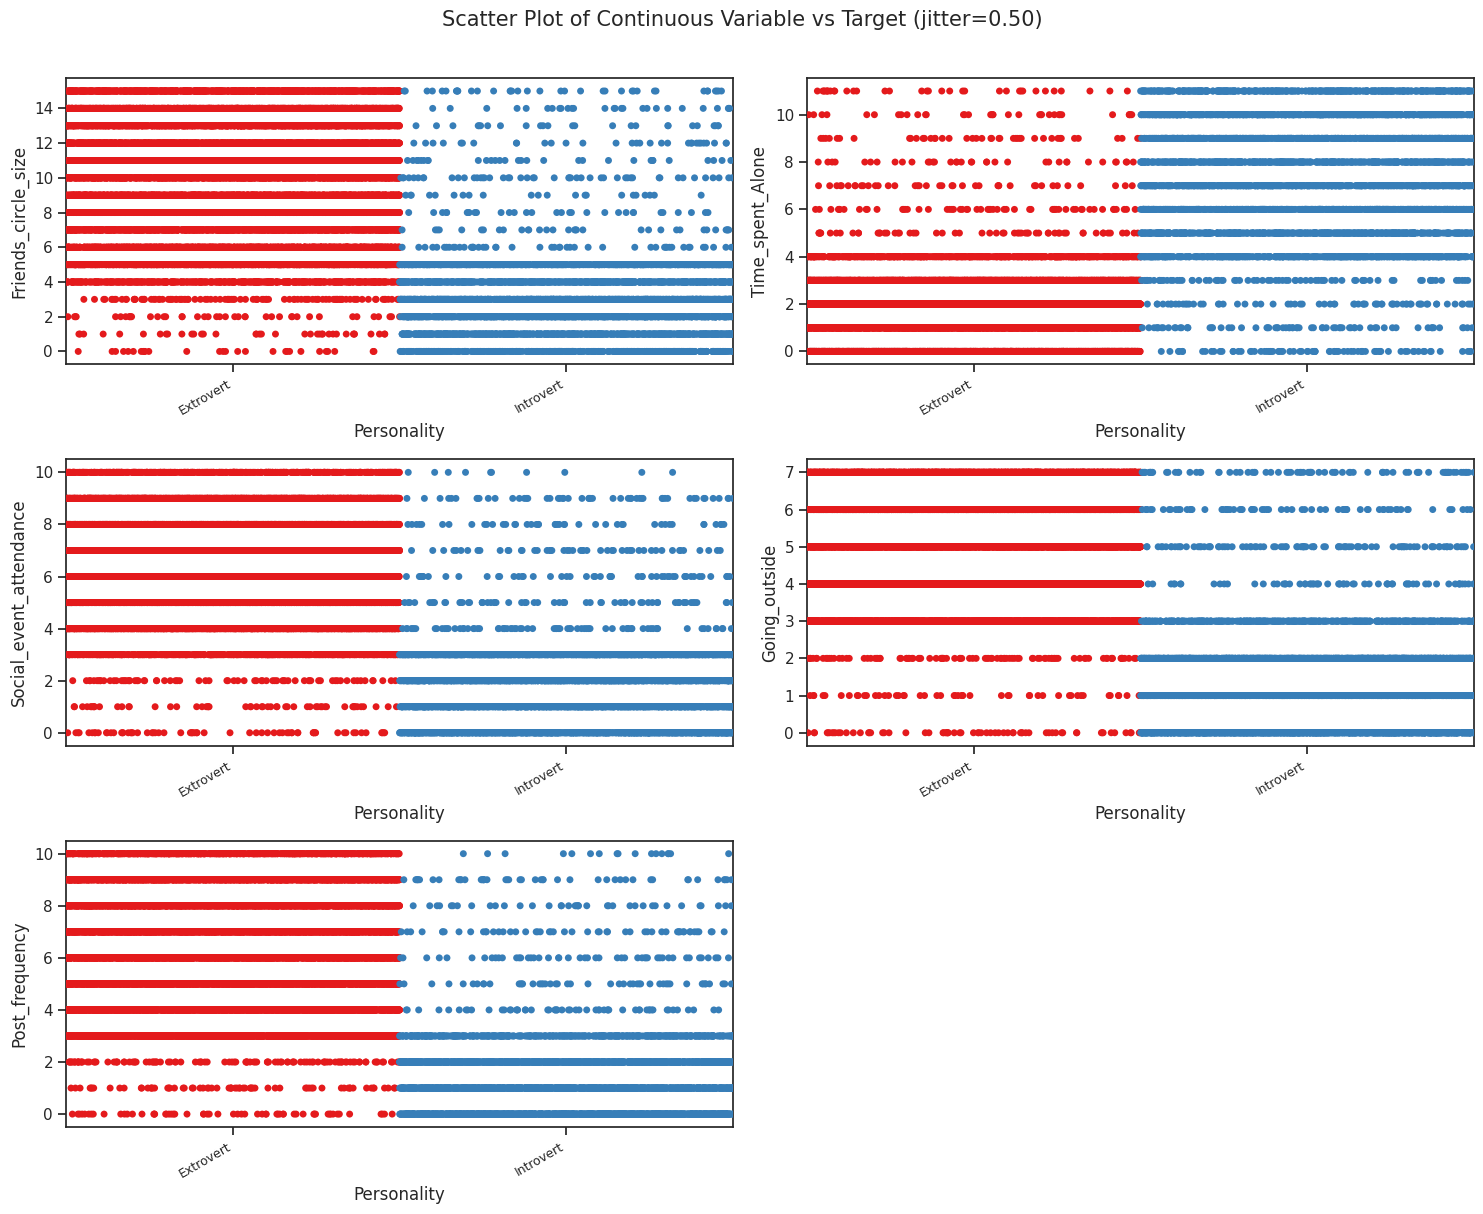

Total Number of Scatter Plots = 15


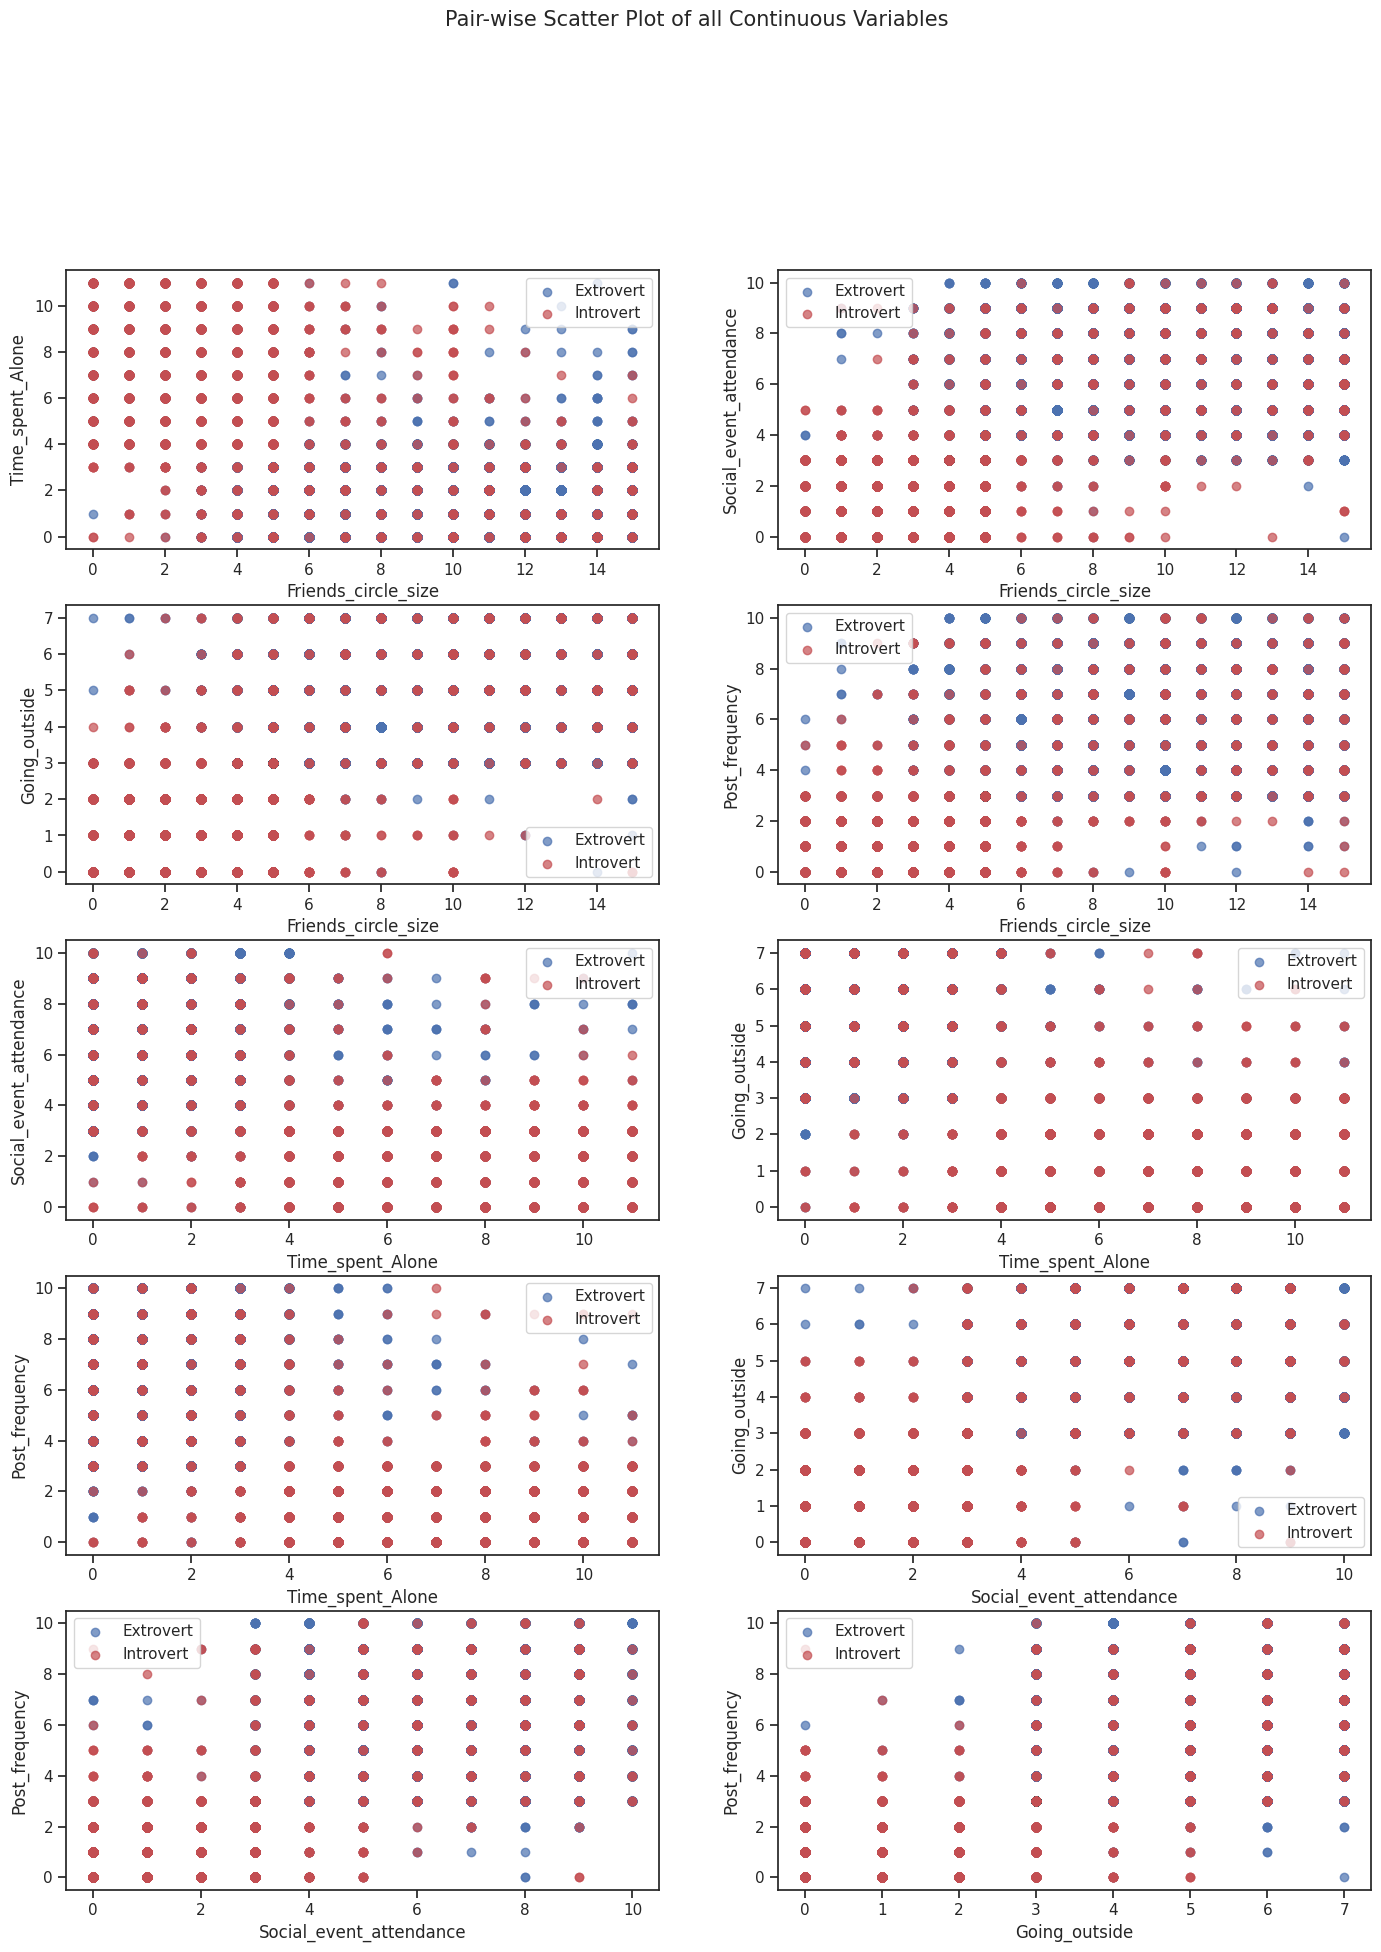

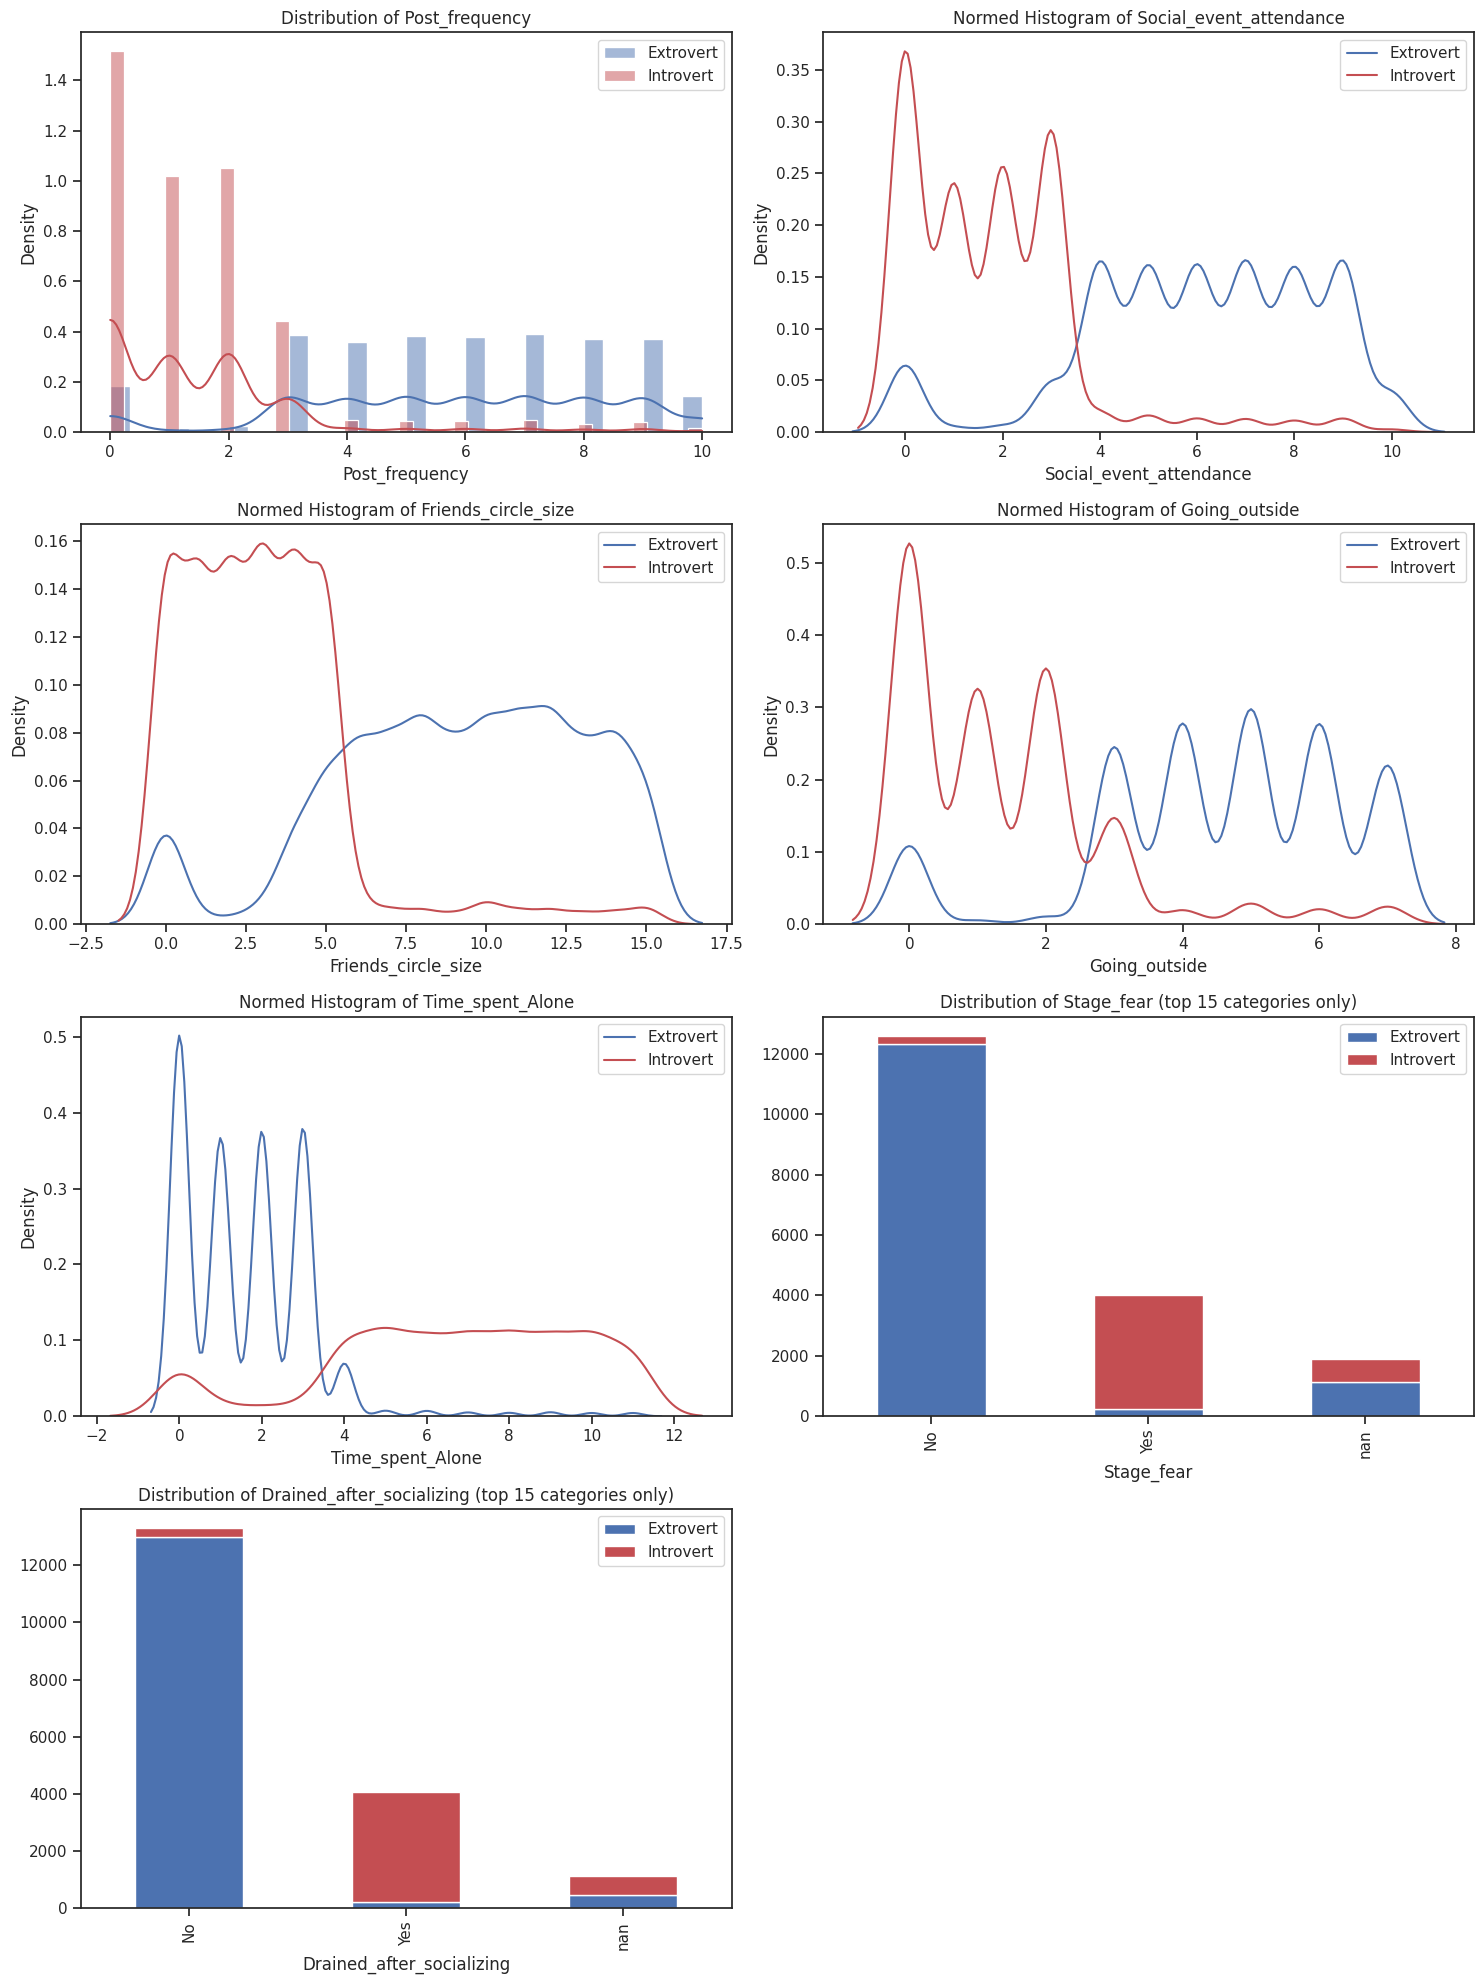

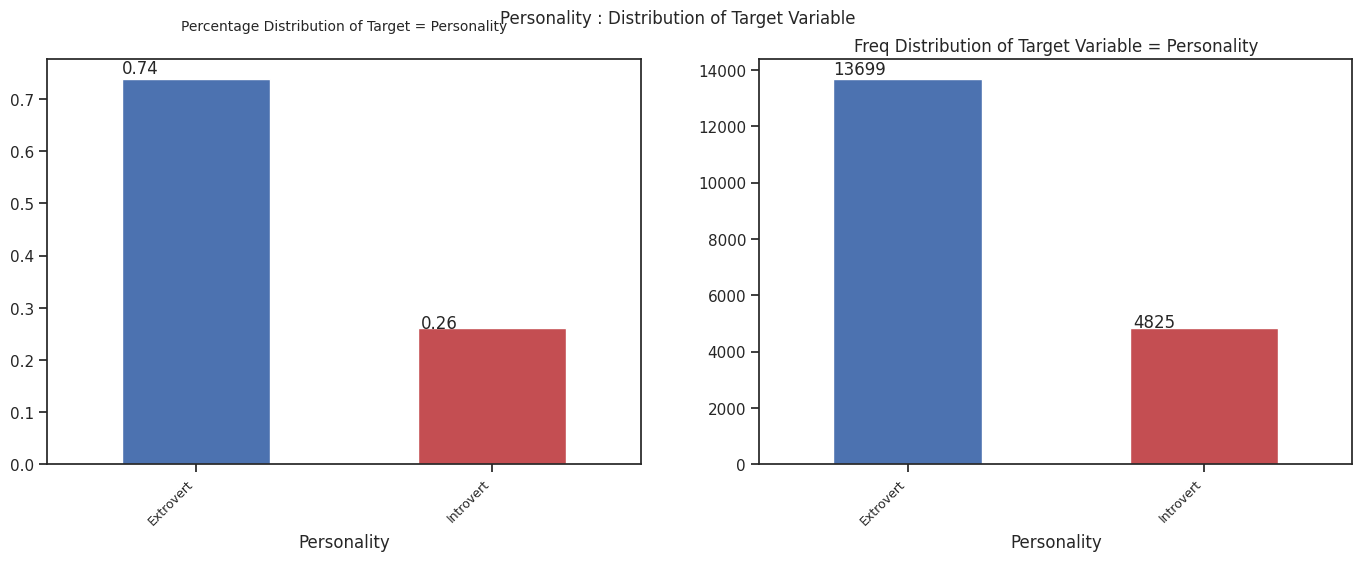

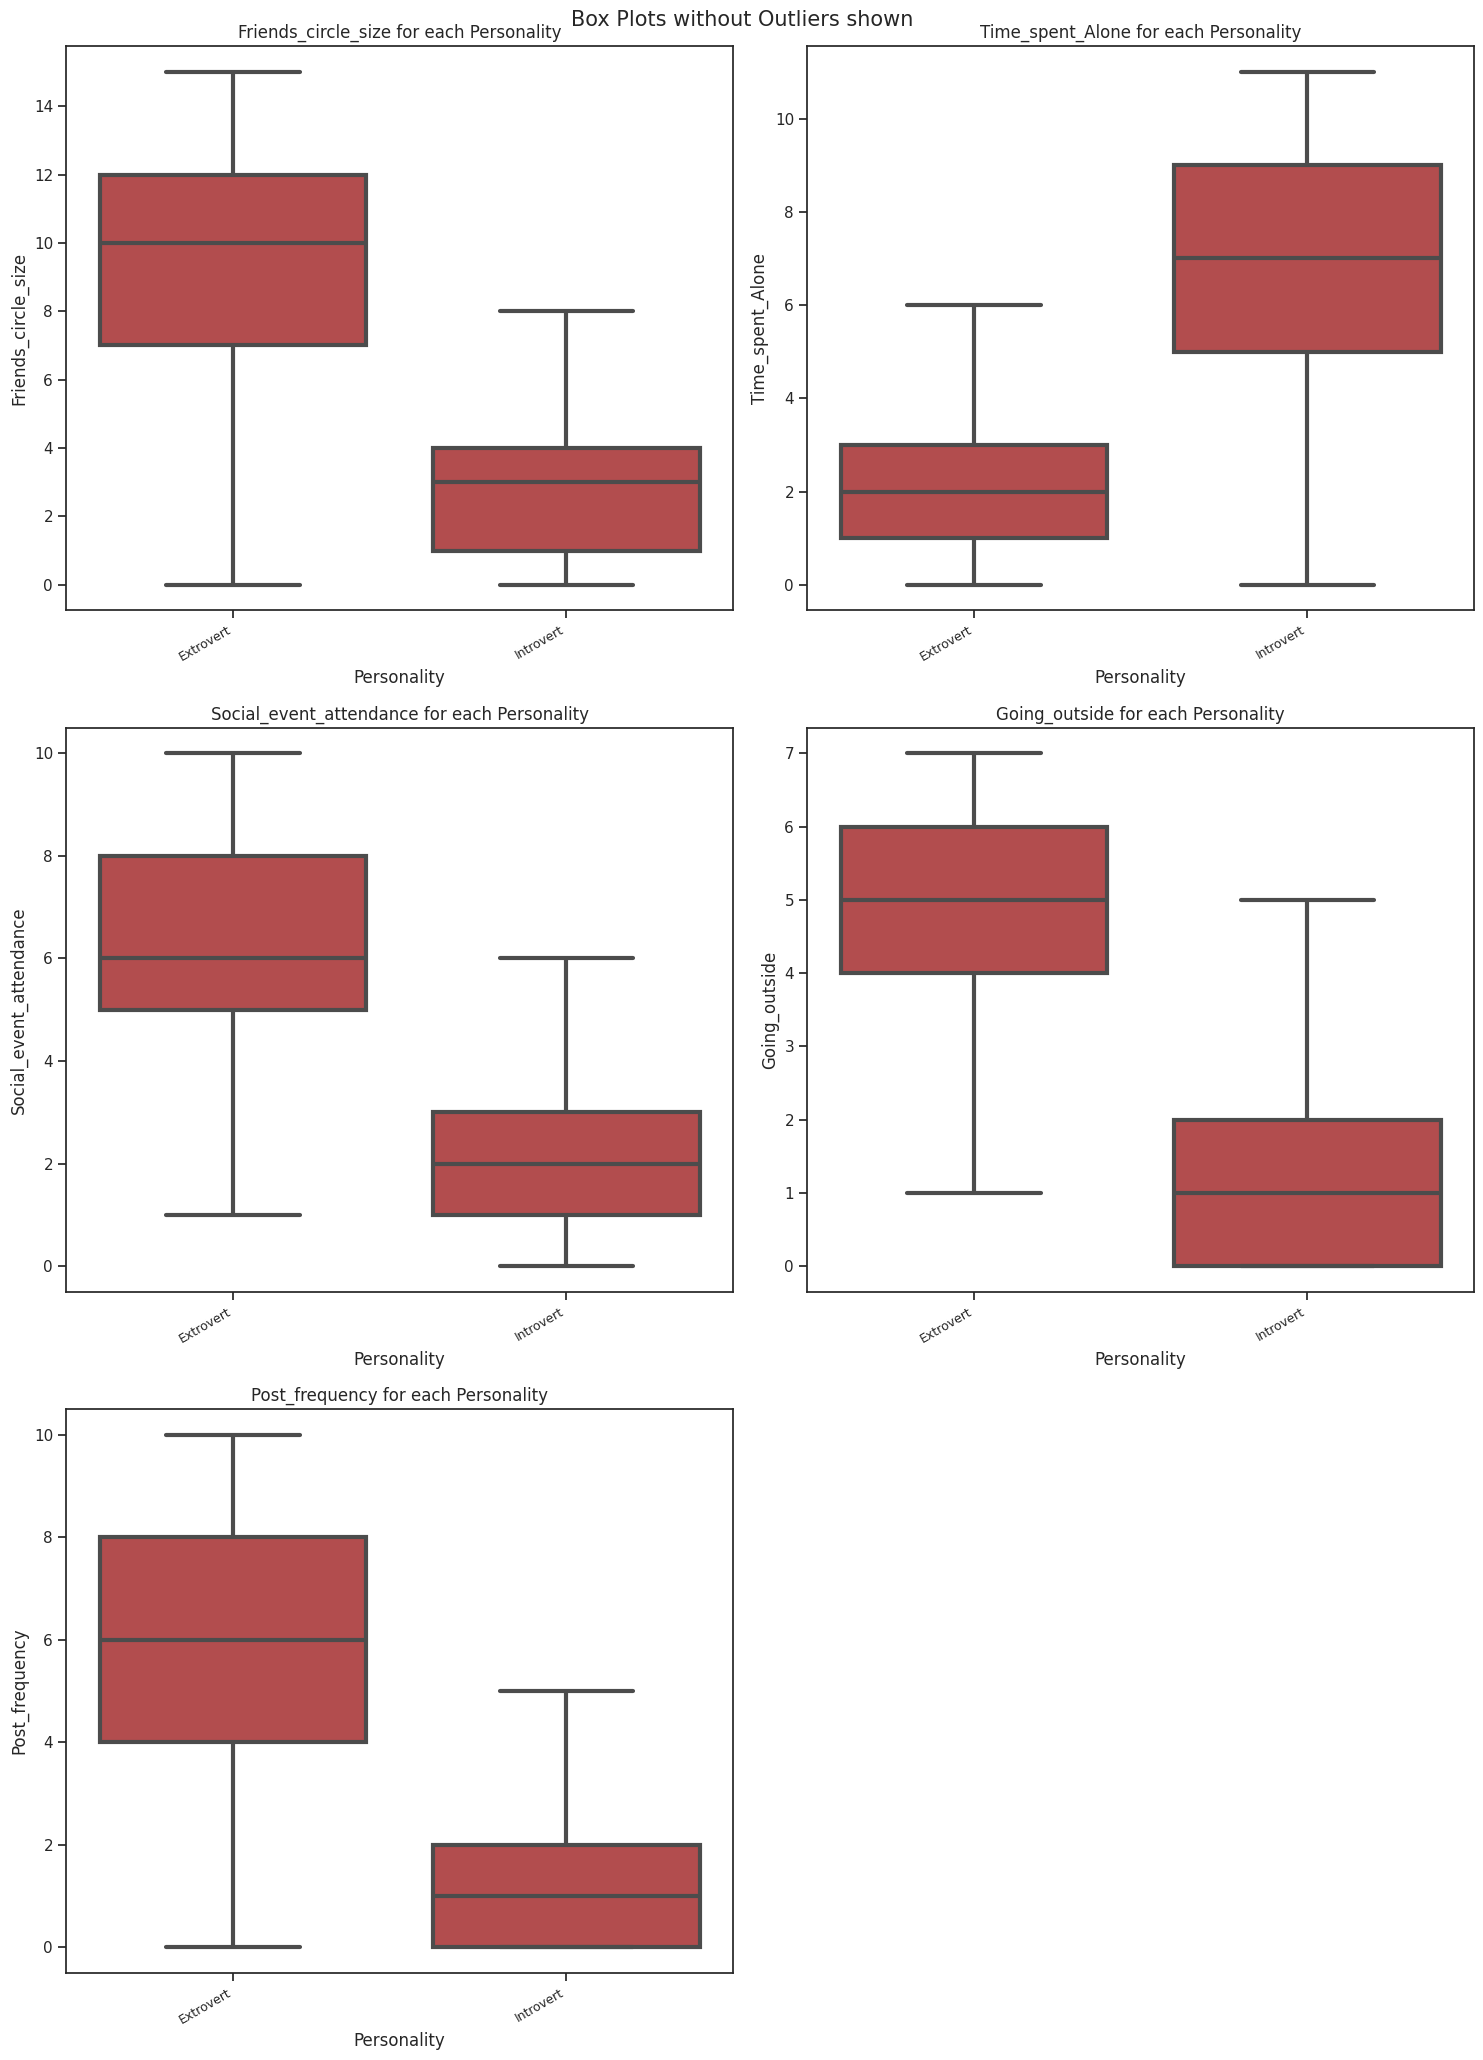

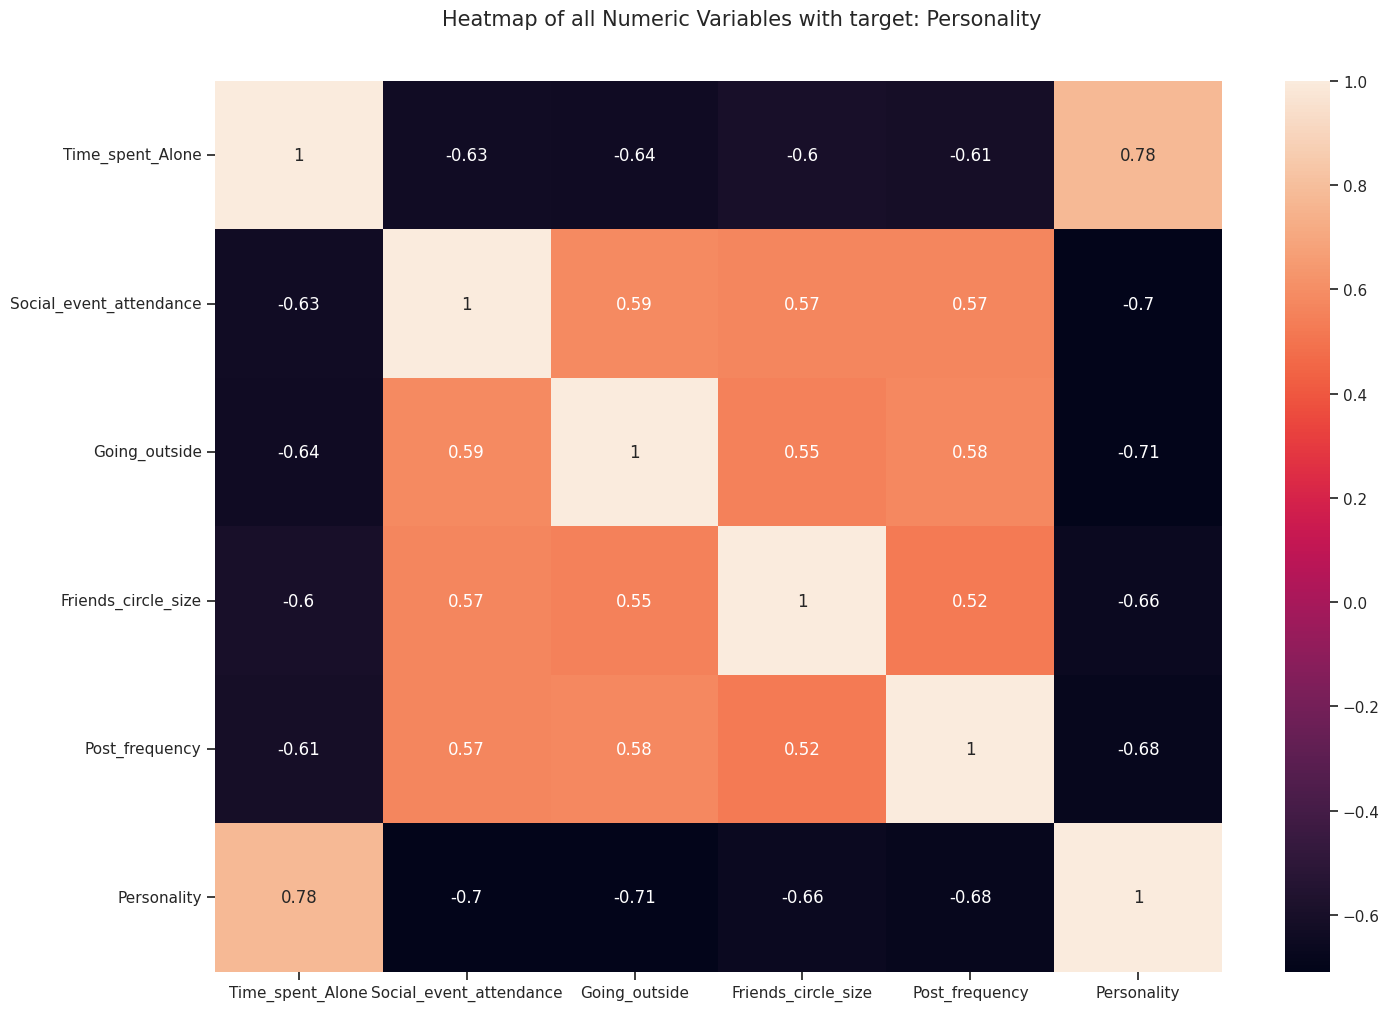

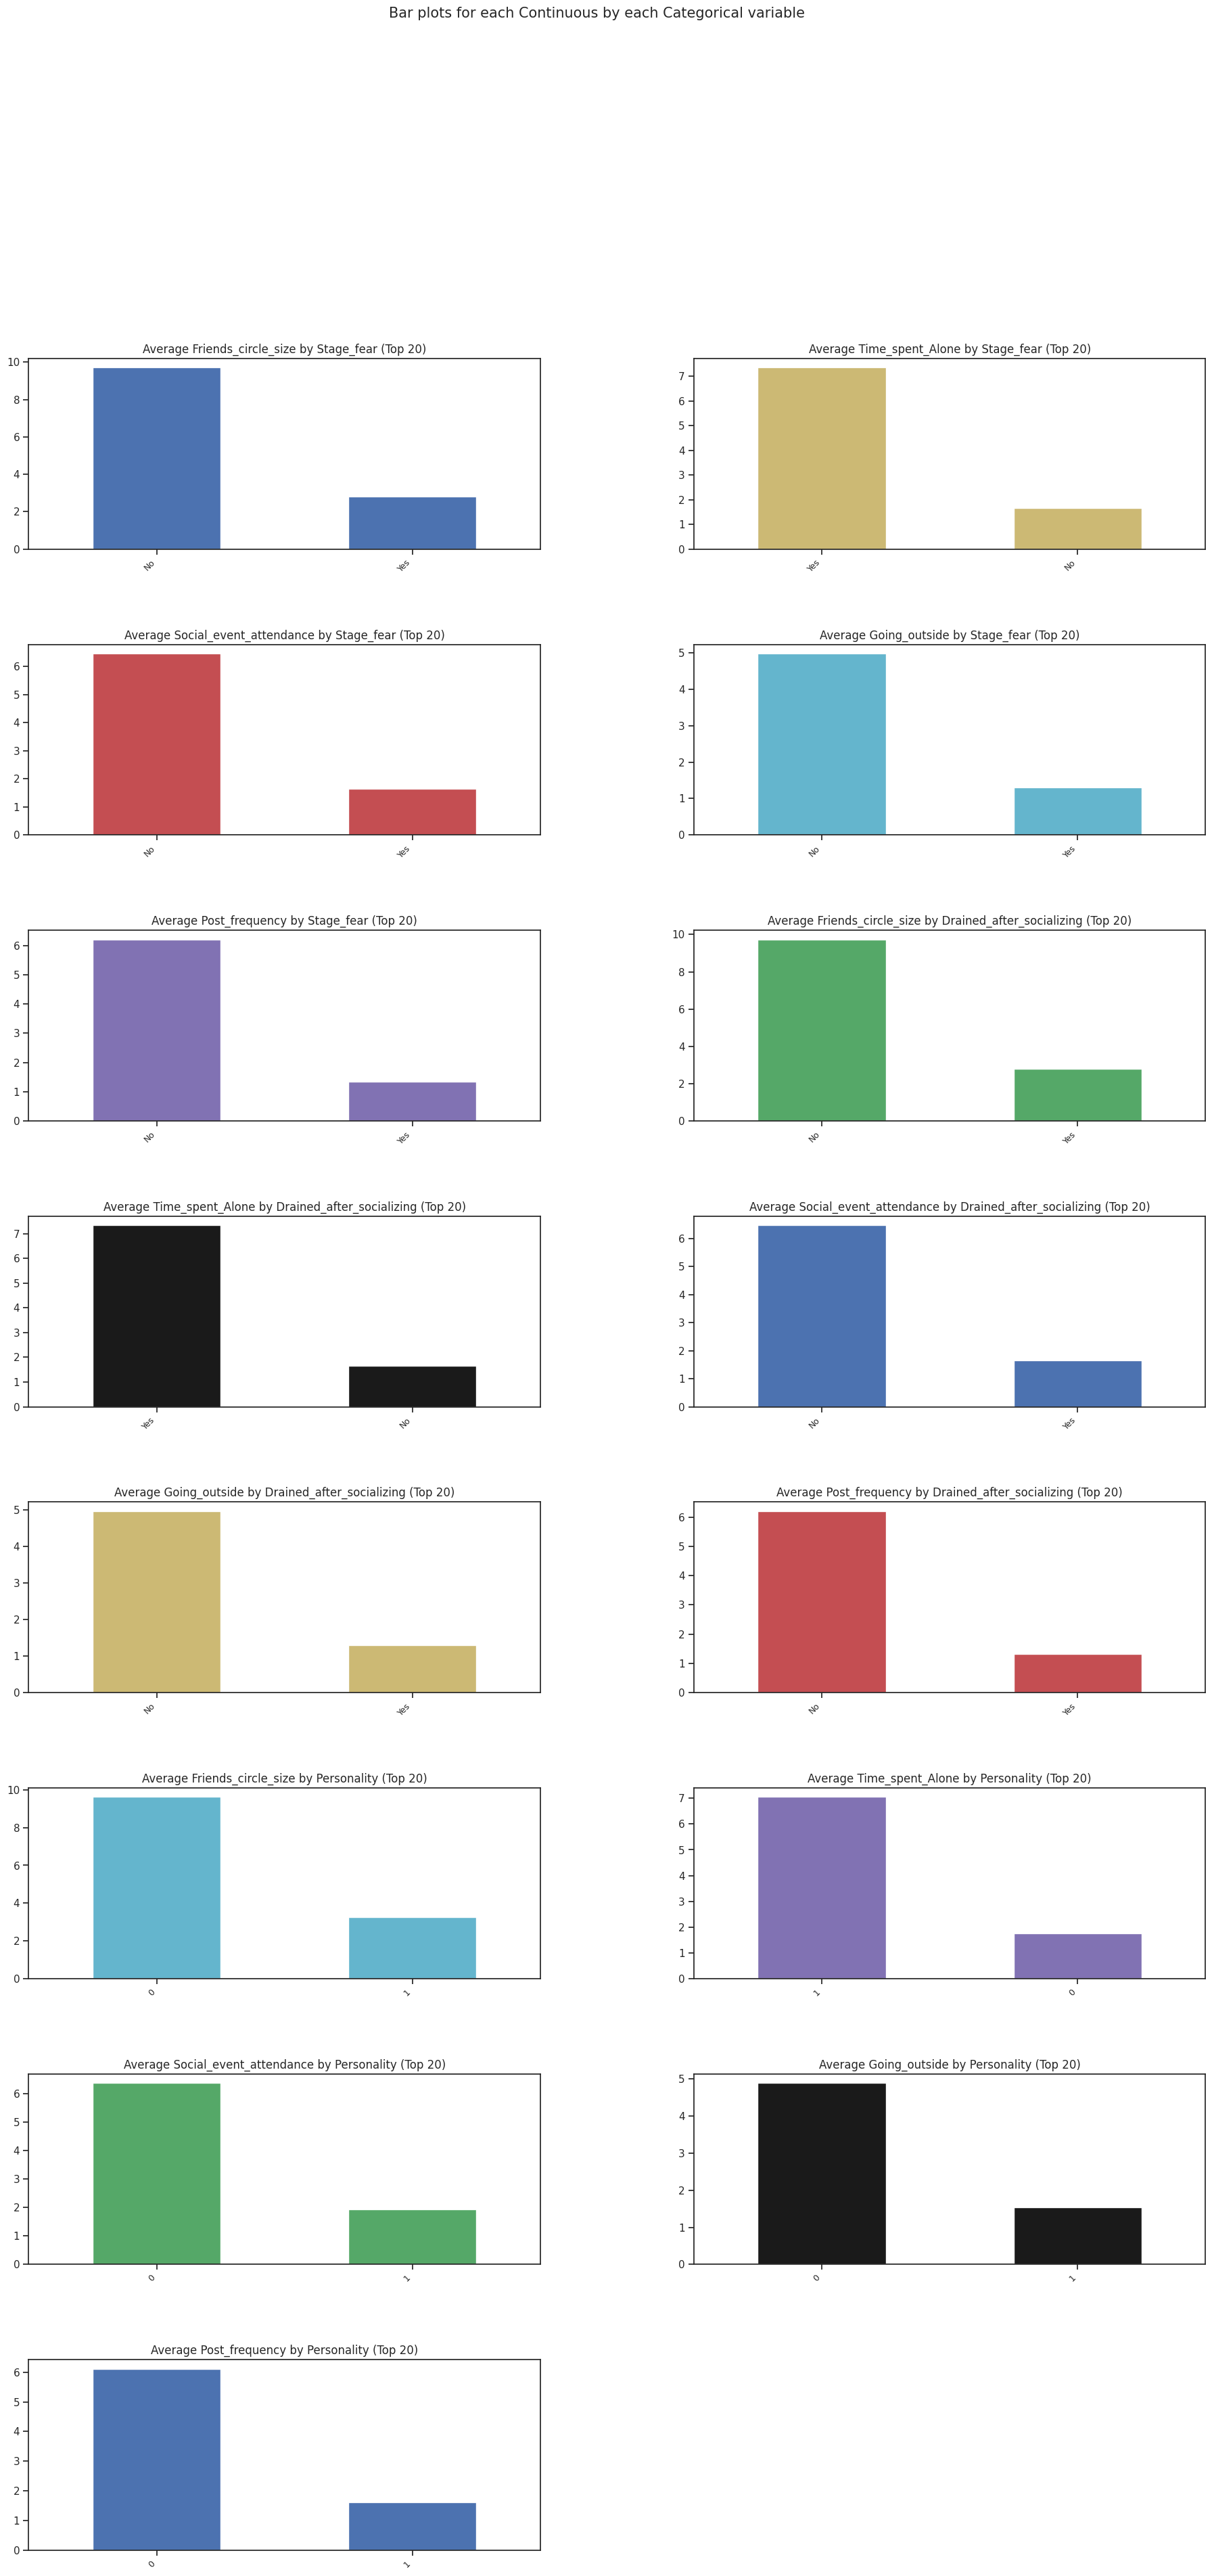

All Plots done
Time to run AutoViz = 19 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,0
1,1.0,No,7.0,3.0,No,10.0,8.0,0
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,1
3,3.0,No,7.0,3.0,No,11.0,5.0,0
4,1.0,No,4.0,4.0,No,13.0,NaN,0
...,...,...,...,...,...,...,...,...
18519,3.0,No,7.0,3.0,No,9.0,7.0,0
18520,1.0,NaN,6.0,7.0,No,6.0,5.0,0
18521,7.0,Yes,1.0,1.0,Yes,1.0,NaN,1


In [10]:
# Creating the Autoviz instance

av = AutoViz_Class()

# To displays plots automatically

%matplotlib inline

# Generating data visualization automatically

av.AutoViz(filename="", dfte=personality_train, depVar="Personality", chart_format="png")

## Personality (Target variable)

Introversion and extroversion are two personality dimensions that describe how people derive energy from and relate to the world. Introverts tend to derive energy from solitude and reflection, while extroverts are energized by social settings and interaction with others. It's important to remember that most people fall somewhere in the middle of the spectrum, which is known as ambiversion.

Introversion:

- Solitude, quiet activities, and reflection are sources of energy for introverts.
- They may feel drained after spending too much time with others and prefer to spend time alone.
- Reserved and reflective, they prefer depth in relationships and can sometimes be perceived as shy or quiet.

Extroversion:

- Social interaction, stimulating activities, and dynamic environments are sources of energy for extroverts.
- They enjoy spending time with others, are sociable, and like to talk and participate in group activities.
- Sociable, talkative, energetic, they like to be the center of attention, sometimes they can be perceived as impulsive.

Source: https://positivepsychology.com/introversion-extroversion-spectrum/

Our target variable, composed of two values, "Extrovert" and "Introvert," shows no missing or erroneous values. We found unbalanced classes, with the "Extrovert" class representing 74% of the samples. We can observe a linear relationship with the numerical variables.

## Time_spent_Alone

This variable determines whether the person prefers to spend time alone or not, we assume in hours. It's logical to find that the values will be high for introverts. Excessive time alone, especially when involuntary, can lead to feelings of loneliness, social withdrawal, and isolation, can make it harder to form and maintain social connections, leading to social isolation and difficulties in social situations. Introverts may naturally gravitate towards solitude and find it beneficial for recharging, while extroverts may find it more challenging and potentially detrimental. It would be interesting to analyze event attendance and outings further along, with this variable, to evaluate relationships.

The variable presents null data, and we did not detect any errors. The range of values is from 0 to 11, with an average of 3. Not only from the graphs, but also from the statistical analysis, we can observe outliers that need to be addressed.

## Stage_fear

The variable establishes a binary categorical classification, with two values: 'No' related to extroverts, and 'Yes', focused on introverts. As a personality analysis factor, it offers insight into an individual's emotional regulation, social behavior, and self-perception. Understanding the underlying causes and associated personality traits can help. It is a situational anxiety, meaning it arises in specific contexts. Introverts may find it more challenging to be the center of attention, as it requires them to step outside their comfort zone.

We found null values to handle, but no erroneous values. Later, we'll ask some interesting questions to assess whether we can generalize each value with the values of the target variable, and consider the values that arise from this logic as atypical.

## Social_event_attendance

Introverts and extroverts differ significantly in their attendance at social events and overall participation. Extroverts tend to thrive in social settings, seek out interactions, and are energized by social situations, while introverts often find social events draining and prefer solitary activities or smaller gatherings.

- Extroverts: They are energized by being around others and actively participate in social events. They tend to prefer larger gatherings and find it easier to connect with others in these settings. They are more likely to start conversations, participate in activities, and be the center of attention.

- Introverts: Large crowds can be overwhelming, and they prefer smaller, more intimate gatherings. After social events, introverts often need time alone to recharge and process their experiences. They are less likely to initiate conversations or take leadership roles in social situations. Introverts often prefer deep, meaningful conversations with a few close friends over large social gatherings and small talk.

The variable consists of, we assume, the number of events the person attends. The values range from 0 to 10, with an average of 5.2. The variable presents null data, but we did not detect any erroneous data. As expected, we found a negatively skewed distribution for extroverts, with a right-sided tail for introverts. We should find a close relationship with the variable drained after socializing.

## Going_outside

In the context of personality analysis, "going outdoors" can have a different interpretation for introverts and extroverts. Extroverts generally feel energized by social interaction and the outside world, while introverts often find their energy renewed in solitude and reflection. For introverts, spending time outdoors can be a way to enjoy nature and solitude, but they may still prefer to avoid large social gatherings or overly stimulating environments. We should find a close relationship between attending social events and this variable. We will analyze this in more depth later. The differences between each class are similar to those mentioned above, due to the close relationship, although it is important to note that going outdoors for an introvert can be high, in addition to being related to the time alone variable, since outings can be solitary, taking into account the characteristic of thinking and reflection.

The values range from 0 to 7, representing the number of outings the person makes, or it could also be considered the number of hours the person spends outdoors. But it logically represents the number of outings. The values have an average of 4. We observe null values, but they are not erroneous. Analyzing the histograms, we can see a similar distribution with social events, which is logical.

## Drained_after_socializing

Feeling exhausted after socializing is a common experience for introverts, who often need time alone to recharge after social interactions. While extroverts gain energy from socializing, introverts tend to find it draining, especially in large or stimulating environments. This difference relates to the way introverts and extroverts process external stimuli and rewards.

Introverts and Socializing: they are more sensitive to external stimuli like noise, crowds, and activity. This can make social situations, particularly large or intense ones, feel overwhelming and draining. Research suggests that introverts have a less active dopamine reward system compared to extroverts. After social events, introverts need time to decompress and recharge through solitary activities like reading, spending time in nature, or engaging in hobbies.

Extroverts and Socializing: Extroverts thrive in social situations and are energized by interacting with others. They tend to be less sensitive to external stimuli and actively seek out social interaction to feel energized and engaged. While extroverts enjoy socializing, they can still experience fatigue from social interactions, especially if they are overly stimulating or prolonged.

We found a binary categorical variable with two possible values. The variable does not present erroneous values, but we did find null values, which could be completed using related variables. We found both values within both classes; these could be considered outliers, although as we previously analyzed, for example, extroverts can sometimes feel tired due to overactivity. We will analyze this in more depth with some interesting questions later.

## Friends_circle_size

Introverts tend to prefer close, intimate relationships with a smaller group of friends, find energy in solitude, and prefer deeper, more meaningful connections. While extroverts tend to have larger circles of friends, they thrive on social interaction and enjoy the company of others.

Extroverts:

- Tend to have larger networks of friends and acquaintances. 
- Enjoy social gatherings and are energized by interacting with others. 
- May have a wider circle of friends, including casual acquaintances. 
- Can find it easier to strike up conversations and form new connections. 

Introverts:

- Typically have smaller, more intimate friend circles.
- Value quality over quantity in friendships.
- May take longer to form close bonds but invest deeply in those relationships.
- Can be selective about who they let into their inner circle.
- May prefer one-on-one interactions or small group settings.

The numerical variable contains a range of values between 0 and 15, with an average of almost 8. These values represent the number of friends the person has. It is notable to find smaller friendship circles among introverts and larger ones among extroverts. This suggests the same distribution we observed in other variables, with different biases for each class. We did not detect erroneous values, but we did find null values. We may find some outliers in the range of values for extroverts; we will analyze this in more depth later.

## Post_frequency

I can't find many specific insights on this variable. What I can gather is that it represents the frequency of socializing or the use of elements or tools for this purpose, for example, social media. Social media use varies between introverts and extroverts. Extroverts tend to interact more actively and frequently, while introverts may use it for different purposes, such as self-expression or social compensation. Extroverts tend to use social media as a tool for communication and connection, posting more frequently and publicly, while introverts prefer to stay away, curate content, or use it for more specific interactions.

We encounter another numerical variable, with a range of values between 0 and 10, with an average of almost 5. The variable presents null values, but not erroneous ones. It would be interesting to analyze whether the variable represents a good separation for each class, since we can likely find a wide range of values based on our insights into what the variable contains. Beyond that, we can observe the same distribution previously observed in other variables. We will analyze this in more depth by asking some questions after preparing the data.

We have completed our first approach to data exploration, which we will return to if necessary after asking some interesting questions later, following our initial handling of the data. Next we will analyze possible duplicates, null data and how to handle them where required, using the information obtained from our previous analysis.

# Data wrangling

We will proceed to analyze and complete the data where necessary, handle null data, duplicates, and outliers.

In [11]:
# We make a copy of the original dataset

personality_new = personality_train.copy()

In [12]:
# We confirm that there is no null values

null_values = pd.DataFrame(
        {"Null Data" : personality_new.isnull().sum(), 
         "Percentage" : (personality_new.isnull().sum()) / (len(personality_new)) * (100)})

null_values

,Null Data,Percentage
Time_spent_Alone,1190,6.424098
Stage_fear,1893,10.219175
Social_event_attendance,1180,6.370114
Going_outside,1466,7.914057
Drained_after_socializing,1149,6.202764
Friends_circle_size,1054,5.689916
Post_frequency,1264,6.823580
Personality,0,0.000000


In [13]:
# We check for duplicate data

print(f"Length: {len(personality_new.duplicated())}")
print(f"Duplicates: {personality_new.duplicated().sum()}")

Length: 18524
Duplicates: 0


In our exploratory analysis, we found some outliers, but we will maintain the original ranges, since only one variable presents them and not at such extreme levels. We will return to this point after making our first approach. Regarding null values, as we had already established in our analysis, they are present in all features, and we were also able to confirm the absence of duplicate values.

In [14]:
def nan_filler(data, column, group, stats):
    
    if stats == "mode":
        data[column] = (
            data[column].fillna(
                data.groupby(group)[column].transform(lambda v: v.mode()[0])))

    else:
        data[column] = (
            data[column].fillna(
                data.groupby(group)[column].transform("mean").round(1)))

    print(
            "Number of null values: ", data[column].isnull().sum(), "\n\n",
            "Distribution of values: \n", data[column].value_counts()
    )

There are many ways to complete missing values, but for our first approach, we'll use a simple method. We begin by creating a function to apply to the features, which completes categorical data with the mode and numerical data with the average, and finally prints a summary to validate the changes. We decided to group the values by personality.

### Time_spent_Alone

In [15]:
nan_filler(personality_new, "Time_spent_Alone", "Personality", "mean")

Number of null values:  0 

 Distribution of values: 
 Time_spent_Alone
0.0     3139
3.0     3081
2.0     3039
1.0     2973
4.0     1079
1.7      909
5.0      633
10.0     587
8.0      582
7.0      581
6.0      574
9.0      574
11.0     492
7.1      281
Name: count, dtype: int64


### Stage_fear

In [16]:
nan_filler(personality_new, "Stage_fear", "Personality", "mode")

Number of null values:  0 

 Distribution of values: 
 Stage_fear
No     13758
Yes     4766
Name: count, dtype: int64


### Social_event_attendance

In [17]:
nan_filler(personality_new, "Social_event_attendance", "Personality", "mean")

Number of null values:  0 

 Distribution of values: 
 Social_event_attendance
4.0     2073
9.0     2063
7.0     2031
5.0     1985
6.0     1984
8.0     1945
3.0     1703
2.0     1063
0.0     1055
1.0      978
6.4      732
10.0     464
1.9      448
Name: count, dtype: int64


### Going_outside

In [18]:
nan_filler(personality_new, "Going_outside", "Personality", "mean")

Number of null values:  0 

 Distribution of values: 
 Going_outside
5.0    2923
3.0    2822
4.0    2703
6.0    2702
7.0    2170
0.0    1324
2.0    1279
1.0    1135
4.9     962
1.5     504
Name: count, dtype: int64


### Drained_after_socializing

In [19]:
nan_filler(personality_new, "Drained_after_socializing", "Personality", "mode")

Number of null values:  0 

 Distribution of values: 
 Drained_after_socializing
No     13775
Yes     4749
Name: count, dtype: int64


### Friends_circle_size

In [20]:
nan_filler(personality_new, "Friends_circle_size", "Personality", "mean")

Number of null values:  0 

 Distribution of values: 
 Friends_circle_size
5.0     1669
12.0    1317
4.0     1317
8.0     1281
10.0    1267
11.0    1253
14.0    1188
6.0     1146
7.0     1124
9.0     1061
13.0    1048
15.0     943
3.0      866
2.0      770
1.0      753
9.6      700
0.0      467
3.3      354
Name: count, dtype: int64


### Post_frequency

In [21]:
nan_filler(personality_new, "Post_frequency", "Personality", "mean")

Number of null values:  0 

 Distribution of values: 
 Post_frequency
3.0     2258
7.0     1827
5.0     1788
6.0     1767
9.0     1744
8.0     1734
4.0     1688
2.0     1291
0.0     1272
1.0     1214
6.1      777
10.0     677
1.6      487
Name: count, dtype: int64


In [22]:
# We changed the format for more efficient memory usage

personality_new[personality_new.select_dtypes(["object"]).columns] = (
    personality_new.select_dtypes(["object"]).apply(
        lambda x: x.astype("category"))
)

In [23]:
personality_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Time_spent_Alone           18524 non-null  float64 
 1   Stage_fear                 18524 non-null  category
 2   Social_event_attendance    18524 non-null  float64 
 3   Going_outside              18524 non-null  float64 
 4   Drained_after_socializing  18524 non-null  category
 5   Friends_circle_size        18524 non-null  float64 
 6   Post_frequency             18524 non-null  float64 
 7   Personality                18524 non-null  category
dtypes: category(3), float64(5)
memory usage: 922.9 KB


We've finished filling in the data. As mentioned previously, there are many methods that could be applied; we're using this one so we can test alternatives to handling null data. A function could be created to apply everything directly to all columns, instead of handling them individually, simplifying the code. Next, we'll double-check for duplicate data that could be generated after applying this method.

In [24]:
# We check again that there are no duplicates

print(f"Length: {len(personality_new.duplicated())}")
print(f"Duplicates: {personality_new.duplicated().sum()}")

Length: 18524
Duplicates: 1636


We were able to detect that after completing the data, duplicate rows were generated. We'll proceed to remove these rows for now, until we complete our initial approach. We can then return to this point and test other methods, since with few features and samples, trying to retain all the data can be important.

Notes: Duplicate data is being generated by filling in null values in both categorical columns. The KNNImputer method was tested, and the number of duplicates generated was higher. The code is provided below.

In [25]:
'''
# We create a useful function

def mapper(data, column, order):
    
    data[column] = data[column].map(order)
    data[column] = data[column].astype("float64")

    print(data[column].value_counts())

order = {"No" : 0, "Yes" : 1}
mapper(personality_new, "Stage_fear", order)
mapper(personality_new, "Drained_after_socializing", order)

# Alternative with KNNimputer

imputer = KNNImputer(n_neighbors=2).set_output(transform="pandas")
knn_train = personality_new.drop(columns="Personality")
After_knn_train = imputer.fit_transform(knn_train)

personality_end = pd.concat([After_knn_train, personality_new["Personality"]], axis=1)

print(f"Length: {len(personality_end.duplicated())}")
print(f"Duplicates: {personality_end.duplicated().sum()}")
'''

'\n# We create a useful function\n\ndef mapper(data, column, order):\n    \n    data[column] = data[column].map(order)\n    data[column] = data[column].astype("float64")\n\n    print(data[column].value_counts())\n\norder = {"No" : 0, "Yes" : 1}\nmapper(personality_new, "Stage_fear", order)\nmapper(personality_new, "Drained_after_socializing", order)\n\n# Alternative with KNNimputer\n\nimputer = KNNImputer(n_neighbors=2).set_output(transform="pandas")\nknn_train = personality_new.drop(columns="Personality")\nAfter_knn_train = imputer.fit_transform(knn_train)\n\npersonality_end = pd.concat([After_knn_train, personality_new["Personality"]], axis=1)\n\nprint(f"Length: {len(personality_end.duplicated())}")\nprint(f"Duplicates: {personality_end.duplicated().sum()}")\n'

KNNImputer method applied: Length: 18524 - Duplicates: 3561

In [26]:
# We remove the duplicates and reset the index

personality_end = personality_new.drop_duplicates()
personality_end.reset_index(inplace=True, drop=True)

In [27]:
personality_end.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16888 entries, 0 to 16887
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Time_spent_Alone           16888 non-null  float64 
 1   Stage_fear                 16888 non-null  category
 2   Social_event_attendance    16888 non-null  float64 
 3   Going_outside              16888 non-null  float64 
 4   Drained_after_socializing  16888 non-null  category
 5   Friends_circle_size        16888 non-null  float64 
 6   Post_frequency             16888 non-null  float64 
 7   Personality                16888 non-null  category
dtypes: category(3), float64(5)
memory usage: 709.7 KB


Once the initial data management process is complete, we continue asking some interesting questions to explore the data in more depth and try to understand more broadly how the features and our target variables relate to and influence each other.